# HexagDLy CNN example

This notebook presents a small CNN example to illustrate the application of HexagDLy in a CNN for classification.

In [1]:
import hexagdly
from hexagdly_tools import plot_hextensor
from example_utils import toy_data, toy_dataset, model

import torch
import torch.nn.functional as F
import torch.nn as nn

import importlib
import numpy as np
import matplotlib.pyplot as plt

First, the hexagonal image data is created via the provided `toy_dataset` class. In this example, hexagonally sampled images with different shapes at different positions are generated. The training and validation sets contains 128 and 64 images of each shape respectively.
The possible shapes to choose from are:

**['small_hexagon', 'medium_hexagon', 'snowflake_1', 'snowflake_2', 'snowflake_3', 'snowflake_4', 'double_hex']**

In [2]:
shape_list = ['snowflake_2', 'snowflake_3', 'snowflake_4', 'double_hex']
val_data = toy_dataset(shape_list, 32)
val_data.create()
val_dataloader = val_data.to_dataloader()
train_data = toy_dataset(shape_list, 128)
train_data.create()
train_dataloader = train_data.to_dataloader()

The lines below show a few example images from the validation set:

<IPython.core.display.Javascript object>


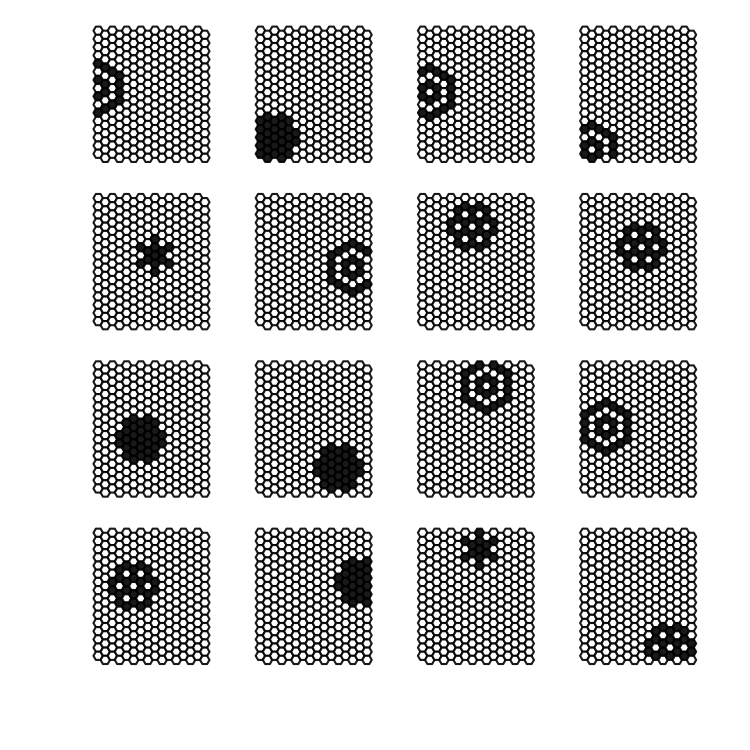

In [3]:
%matplotlib notebook
val_tensor = val_data.to_torch_tensor()
plot_hextensor(val_tensor, image_range=(0,16), channel_range=(0,None), figname='val_examples')

Next, a small CNN network is created that uses the convolution and pooling operations provided by HexagDLy. The API is the same as in PyTorch.

In [4]:
class fc(nn.Module):
    def __init__(self, in_features, out_features):
        super(fc, self).__init__()
        self.ops = nn.Sequential(nn.Linear(in_features, out_features),
                                 nn.ReLU())
    def forward(self, input):
        return self.ops(input)


class hex_model(nn.Module):
    def __init__(self, nout, plot=False):
        super(hex_model, self).__init__()
        self.name = 'hex_model'
        self.plot=plot
        self.hexconv_1 = hexagdly.Conv2d(in_channels = 1, out_channels = 4, \
                                         kernel_size = 1, stride = 1, bias=True)
        self.hexpool = hexagdly.MaxPool2d(kernel_size = 1, stride = 2)
        self.hexconv_2 = hexagdly.Conv2d(4, 8, 1, 1, bias=True)

        self.fc = nn.Sequential(fc(512, 128),
                                nn.Dropout(0.5),
                                fc(128, 64),
                                nn.Linear(64, nout))

    def forward(self, x, ni=0):
        x = self.hexconv_1(x)
        
        # Option to plot first conv layer output
        if self.plot:
            plot_hextensor(x, image_range=(ni,ni+1), channel_range=(0,None), figname='after_first_hexconv')
            
        x = F.relu(x)
        x = self.hexpool(x)
        x = self.hexconv_2(x)
        
        # Option to plot second conv layer output
        if self.plot:
            plot_hextensor(x, image_range=(ni,ni+1), channel_range=(0,None), figname='after_second_hexconv')
            
        x = F.relu(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

 The training and validation data are loaded into the model and the CNN is trained for a few epochs:

In [5]:
net = hex_model(len(shape_list))
epochs = 10
cnn_model = model(train_dataloader, val_dataloader, net, epochs=epochs)
cnn_model.train()
cnn_model.save_current()

Epoch 1
epoch: 1 (0.250) training -    16 batches -> mean loss: 1.390, lr: 0.005, mean acc.: 21.09 %
epoch: 1 (0.500) training -    32 batches -> mean loss: 1.382, lr: 0.005, mean acc.: 30.47 %
epoch: 1 (0.750) training -    48 batches -> mean loss: 1.392, lr: 0.005, mean acc.: 19.53 %
epoch: 1 (1.000) training -    64 batches -> mean loss: 1.381, lr: 0.005, mean acc.: 31.25 %
epoch: 1 (0.250) train_lc -    16 batches -> mean loss: 1.362, lr: 0.005, mean acc.: 36.72 %
epoch: 1 (0.500) train_lc -    32 batches -> mean loss: 1.346, lr: 0.005, mean acc.: 39.84 %
epoch: 1 (0.750) train_lc -    48 batches -> mean loss: 1.344, lr: 0.005, mean acc.: 35.16 %
epoch: 1 (1.000) train_lc -    64 batches -> mean loss: 1.335, lr: 0.005, mean acc.: 32.81 %
epoch: 1 (1.000) val_lc -    16 batches -> mean loss: 1.364, lr: 0.005, mean acc.: 24.22 %
Epoch 2
epoch: 2 (1.250) training -    16 batches -> mean loss: 1.341, lr: 0.005, mean acc.: 31.25 %
epoch: 2 (1.500) training -    32 batches -> mean loss: 

epoch: 10 (10.000) train_lc -    64 batches -> mean loss: 0.014, lr: 0.005, mean acc.: 100.00 %
epoch: 10 (10.000) val_lc -    16 batches -> mean loss: 0.014, lr: 0.005, mean acc.: 100.00 %


Looking at the learning curves, one can see that the model does learn to distinguish the different shapes. The accuracy of course depends on the number of training events, the number of epochs the model is trained and on the combination of shapes in the training data.

<IPython.core.display.Javascript object>


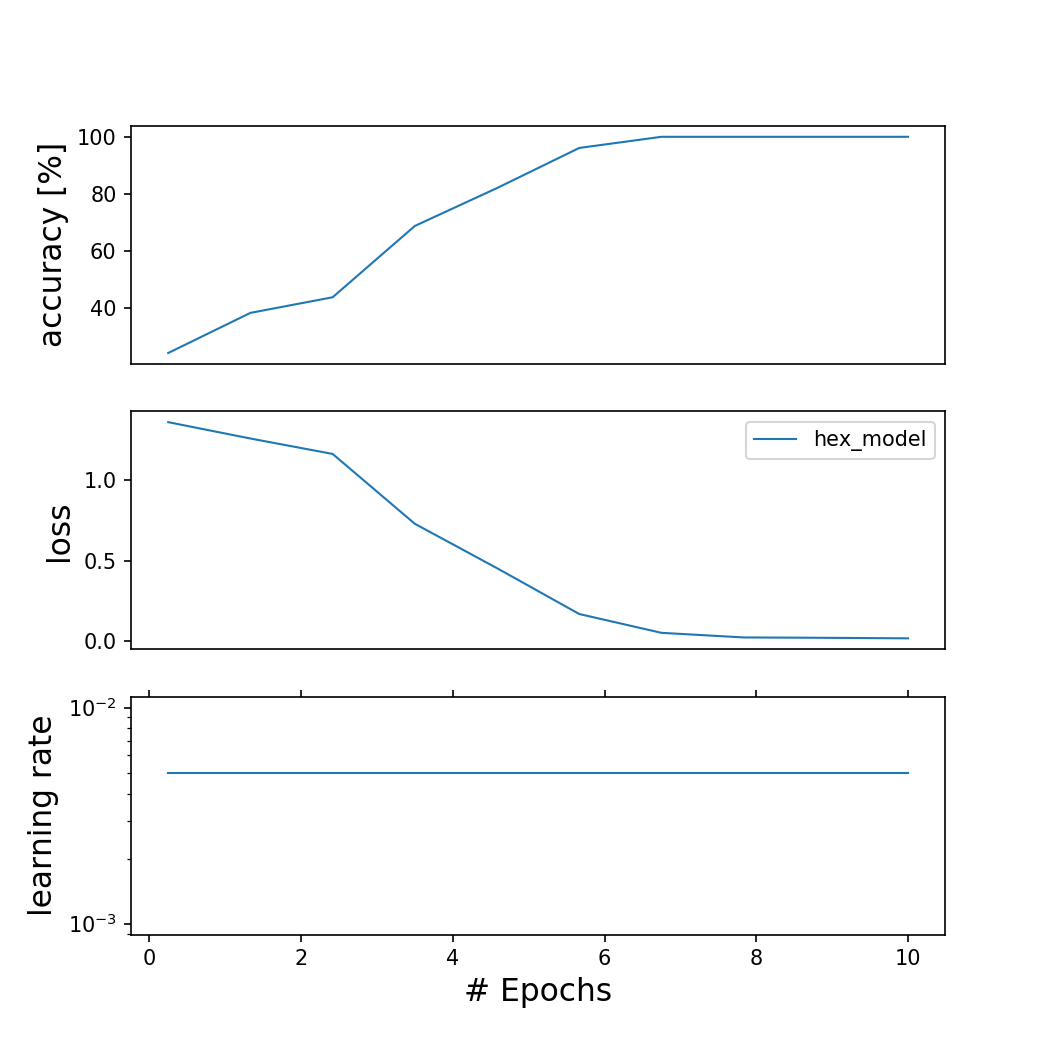

In [6]:
cnn_model.plot_lc()

To probe the model in detail, a test image is created in which a hexagonal shape is located at a given position. By changing the `px` and `py` values (corresponding to the column and row of the center of the shape) the shape can be moved to an arbitrary position.

<IPython.core.display.Javascript object>


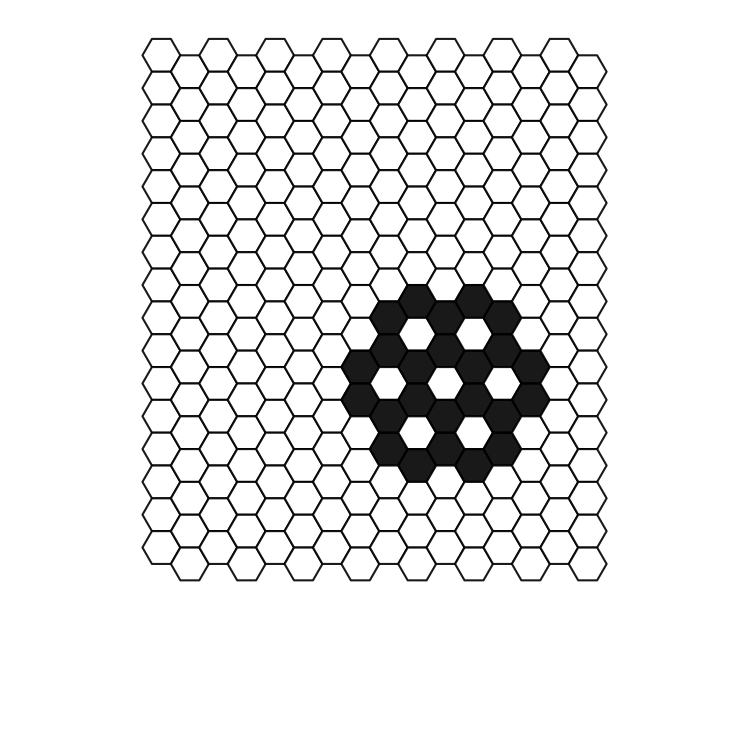

In [7]:
test_shape = 'snowflake_3'
image = toy_data(test_shape, 16, 16, 1, 1, px=10, py=10)
testimage = image.to_torch_tensor()
plot_hextensor(testimage, figname='test_shape')

In the next step, the trained model parameters are loaded into the model with the plot parameter set to `True` to visualize the featuremaps:

<IPython.core.display.Javascript object>


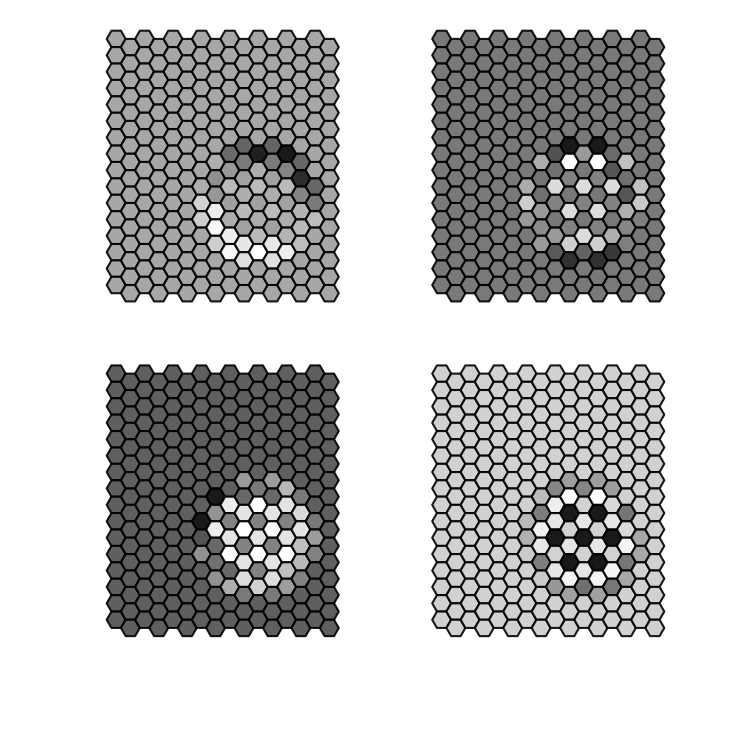

<IPython.core.display.Javascript object>


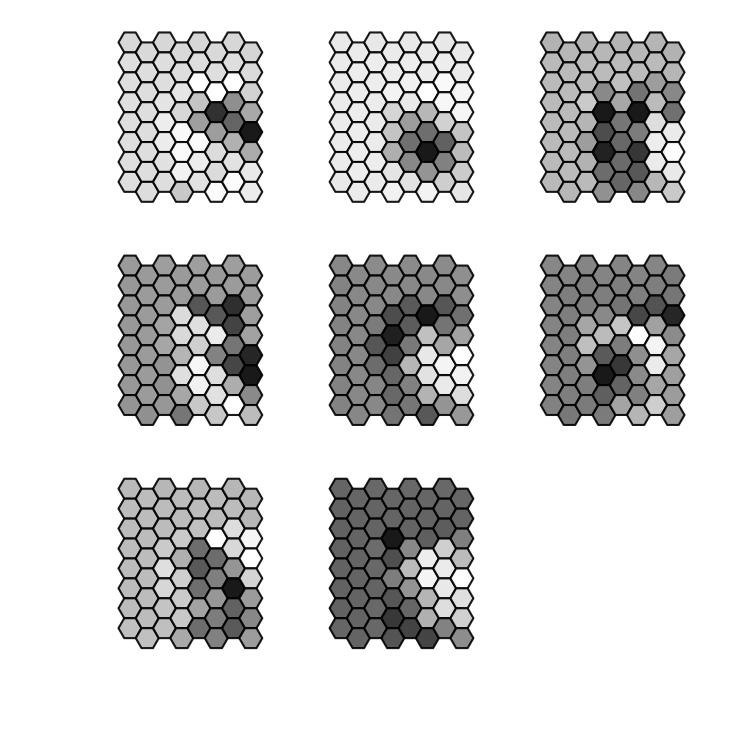

In [8]:
net_plot = hex_model(len(shape_list), plot=True)
net_plot.load_state_dict(torch.load('./hex_model_'+str(epochs)+'.ptmodel'))
plot_out = net_plot(testimage)
net_out = net(testimage)

To get the probability of the test_shape to belong to a certain class, the CNN output has to be fed into a softmax function:

In [9]:
probs = F.softmax(net_out, dim=-1)
sp, si = torch.sort(probs,-1)
for n,(p, i) in enumerate(zip(sp.data.numpy()[0][::-1], si.data.numpy()[0][::-1])):
    if n==0 and shape_list[i]==test_shape:
        print('CNN is CORRECT!')
    elif n==0 and shape_list[i]!=test_shape:
        print('CNN is wrong...')
    print('\t',n+1,' with',np.round(100*p,3), '% ',shape_list[i])

CNN is CORRECT!
	 1  with 99.405 %  snowflake_3
	 2  with 0.595 %  double_hex
	 3  with 0.0 %  snowflake_4
	 4  with 0.0 %  snowflake_2
